# Twitter and Trump: Love or Hate?

![png](T2tweet1.png)

### by Derek Miller and Koa Fisher

In [1]:
# import statements
import utils as ut
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
reload(ut)
plt.style.use('acme')

/usr/local/anaconda2/lib/python2.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
#c,df,T = ut.make_train_test()
fname = ut.get_file()
T = pd.read_csv(fname)
T.index = pd.to_datetime(T['ts'],unit='ms') - pd.DateOffset(hours=7)
T.tail()
df = pd.read_csv("../../../trumpdf.csv")
df.index = pd.to_datetime(df['ts'],unit='ms') - pd.DateOffset(hours=7)


	Options

            1: trump from lab computer

            2: trump from linux mint

            3: clean trump from lab computer

            4: clean trump from linux mint


Enter number >> 3


## The Problem

![png](T2pointing.png)

Donald Trump was the president elect of the United States. The goal of this project is to explore sentiment of Twitter users with regards to the recent political election. We explored sentiment in individual tweets over time and developed generalized methods to identify tweets belonging to a particular sentiment in order to move closer to identifying echo chambers. Some of these methods were successful at classifying tweets as being pro-Trump or anti-Trump in sentiment. Others were not successful at this classification. We will show the insights we have found so far and what the next steps are to use these methods to help identify so-called political echo chambers on Twitter.

### Current Research

Sentiment can be tracked as it develops over time. The ability to classify a positive or negative sentiment at a specific time will allow us to follow the change of how disgruntled or gruntled Twitter is with the progress of the election. The data that this project investigates necessarily involves past, present, and future data associated with keywords used in the API. Since political sentiment changes over time, we planned to use machine learning to predict the political sentiment of a tweet using tweet data gathered leading up to election day. Some have already successfully classified tweets this way. One study used machine learning to predict political orientation and measure political homophily on Twitter. The results provide evidence of certain attributes being linked to increased political homophily (see Colleoni, Rozza, and Arvidsson, 2014). Our goal is to also find successful ways to classify tweet sentiment.

### Data Preparation

Twitter data is readily available at no cost through Twitter’s Streaming and Rest APIs. The company also provides a convenient method for sharing information through the retweet (RT). Furthermore, tweets are limited in the amount of characters that can be sent. This makes large-scale analysis much easier. Twitter's Streaming API delivers a randomized sample of incoming tweets that contain a keyword chosen by the developer. The tweet data is delivered in JSON format and contains several variables related to the tweet as well as the person who sent the tweet. Data collection commenced using Twitter’s Streaming API on 19 October 2016. Bad JSON data, computer processing errors, or internet deficiencies made continuous data collection unreliable. Instead, data was collected semi-frequently until a few days before election day. Starting 5 November 2016, tweets were collected every day until election day. On election day, data were collected continuously begining at 6:00 pm until almost 2:00 am on 9 November 2016. More data was periodically collected during smaller time intervals. The variables collected were the time the tweet was sent (Unix timestamp), the number of user followers, the number of user friends, the number of user tweets to date, and the text of the tweet. In order to work more efficiently with the data, we have a Python module called `utils.py` to store and work with the data in an object called TwitterCorpus.

The TwitterCorpus object has a variety of methods for data cleaning and feature extraction. The principle method is the `clean_text` method. It uses regular expressions to go through each tweet and identify and store certain attributes of the tweet as an attribute of the TwitterCorpus object. The method accepts a keyword `remove_vars_from_tweet` which is a boolean variable that determines whether or not to remove the extracted variables from the tweet after they have been stored as a TwitterCorpus attribute. For the purposes of this exposition, the variables will remain in the tweets.

Each observation corresponds to a tweet. Below are the variable names and their corresponding descriptions:

+ **time** the date and time the tweet was collected. Time is in standard 24 hour format.

+ **usr_fol** the number of people following the user

+ **usr_n_stat** the number of statuses (tweets) to date of the user

+ **usr_fri** the number of people that the user is following

+ **n_weblinks** the number of URLs in the tweet

+ **n_mentions** the number of people mentioned in the tweet

+ **n_hashtags** the number of hashtags in the tweet

+ **RT** whether or not the tweet was a retweet

Another method is the `convert_time` method. This takes the Unix timestamp of the tweet and converts it into a `datetime` object which is part of the `python` standard library. This is helpful for time-series analyses performed on the data. These methods are demonstrated below.

The TwitterCorpus object can also generate pandas `DataFrame` objects of the tweet variable statistics. There were 2,666,819 tweets collected for the Trump data set and 2,124,664 tweets collected for the Clinton data set on or before 9 November 2016. As mentioned before we will only be utilizing the keyword "Trump" due to the outcome of the election. We will onlly analyze the sentiment of tweets regarding Trump.

The following is showing how the data is read and becomes the TwitterCorpus object and the calls to appropriate member functions in order to change the data to a dataframe that we will use.

Along with the previously mentioned variables in our dataframe we also add quantitive values for the sentiment of a tweet. These scores are given as follows:

+ **neg** Negative score.

+ **neu** Neutral score.

+ **pos** Positive score.

+ **comp** Composite score calculated as a normalized aggregate of the negative, neutral, and positive scores.

These are the features we will be using in order to train and test various models in order to classify sentiment of Trump tweets. This will also allow for us to look later at how the sentiment changes with time and whether or not we would have the capacity to predict the sentiment of future tweets according to Trumps actions.

In [3]:
df.head()

,ts,usr_fol,usr_n_stat,usr_fri,n_weblinks,n_mentions,n_hashtags,RT,neg,neu,pos,comp,text
ts,,,,,,,,,,,,,
2016-10-19 07:00:13.849,1476885613849,684.0,4048.0,1221.0,1,2,0,0,0.000,0.811,0.189,0.4215,I liked a @YouTube video from @thefader https:...
2016-10-19 07:00:14.680,1476885614680,90.0,772.0,107.0,1,0,0,0,0.169,0.608,0.223,0.2023,"Trump Calls US Elections Rigged, Blockchain Co..."
2016-10-19 07:00:14.523,1476885614523,242.0,11124.0,273.0,0,0,1,0,0.101,0.776,0.123,0.1440,Because most men are good guys and realize and...
2016-10-19 07:00:14.734,1476885614734,10.0,271.0,10.0,0,3,0,0,0.164,0.643,0.193,0.1027,@hmrstrm45 @mitchellvii @nypost I'm smart enou...
2016-10-19 07:00:14.711,1476885614711,1730.0,27397.0,2370.0,1,1,0,1,0.000,1.000,0.000,0.0000,RT @kurteichenwald: After decades of wrecking ...


Along with the dataframe, data on the actual tweets is also available. The TwitterCorpus object extracts the hashtags and mentions from the text of the tweets. A mention is when the user includes in their tweet the Twitter handle of a different user.

If echo chambers exist in the Trump data set, there may be a difference between tweets and retweets. Below are the tables comparing a selection of summary statistics of tweets and retweets from the Trump data set. Notice that the mean and standard deviation of the usr_fol variable is much smaller for the retweet data set. The retweet data set also has more mentions on average than the tweet data set.

## Exploratory Data Analysis
![png](T2happytweet.png)

After giving the tweets an emotion score, we plotted histograms to see the distribution of the scores. The data did not disappoint. The plots below show the distribution of tweets based on net emotion (positive score minus negative score) as well as the distribution of tweets with a neutral emotion score. In the top histogram, the tall bar in the middle represents tweets with an emotion score of zero. This corresponds to the tall bar in the lower histogram, which represents tweets that were 100% neutral. This means that most tweets about Trump were neither angry nor happy.

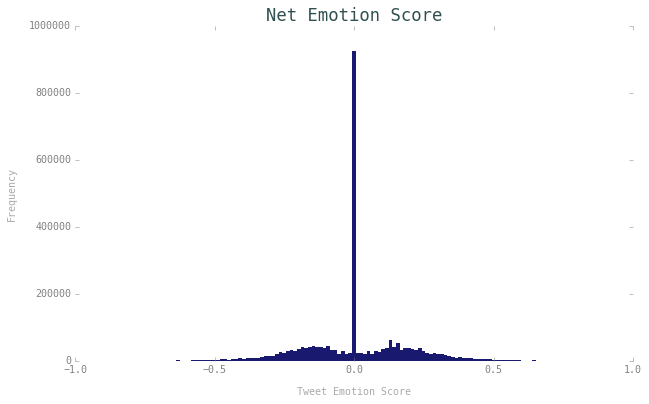

In [4]:
(df['pos']-df['neg']).plot(kind='hist',bins=150,linewidth=0)
plt.title("Net Emotion Score")
plt.xlabel("Tweet Emotion Score")
plt.show()

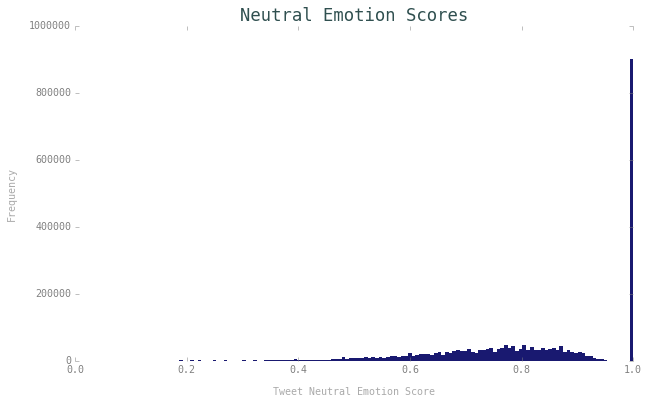

In [5]:
df['neu'].plot(kind='hist',bins=150,linewidth=0)
plt.title("Neutral Emotion Scores")
plt.xlabel("Tweet Neutral Emotion Score")
plt.show()

We expected tweets to be very polarized, but the data defied our expectations. This doesn't mean that people don't say bad things about Trump---just that the language used in the tweets are mostly neutral. For example, a tweet might read "I can't believe Trump is our president". The statement itself is neutral but the hidden sentiment is probably negative given the context of the election. But this is very subtle and identifying these subtle features of language using computers is still in its infancy. Since we expected polarized sentiment, we modified the data set by removing all the strictly neutral tweets. This helps the machine learning algorithms avoid confusion by avoiding the ambiguous neutral tweets. The adjusted distributions are visualized below.

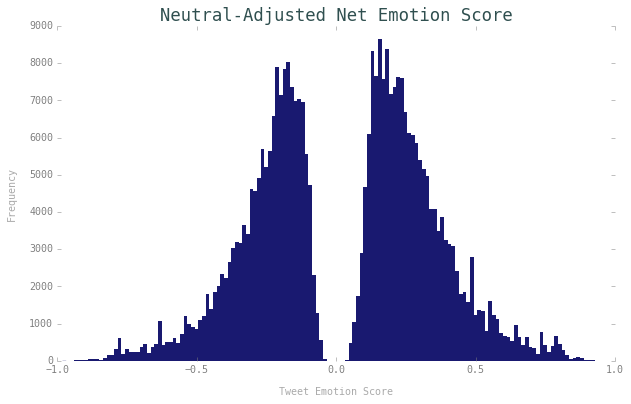

In [6]:
T['pos-neg'].plot(kind='hist',bins=150,linewidth=0)
plt.title("Neutral-Adjusted Net Emotion Score")
plt.xlabel("Tweet Emotion Score")
plt.show()

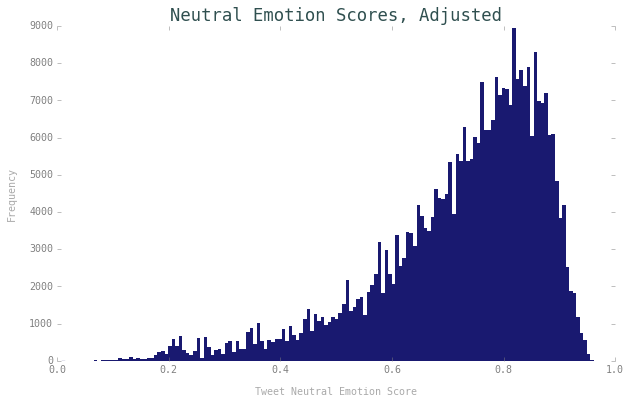

In [7]:
T['neu'].plot(kind='hist',bins=150,linewidth=0)
plt.title("Neutral Emotion Scores, Adjusted")
plt.xlabel("Tweet Neutral Emotion Score")
plt.show()

In general, people don't change their minds very often. But emotions of a population might change on average over time. This is similar to the stock market in the sense that most stock prices don't change too much on any given day, but the stock market as a whole may trend up or down due to market forces. In order to observe trends in Twitter emotion, we chose to look at the average of the sentiments over minute intervals. The following plot shows the average emotion over the course of election day.


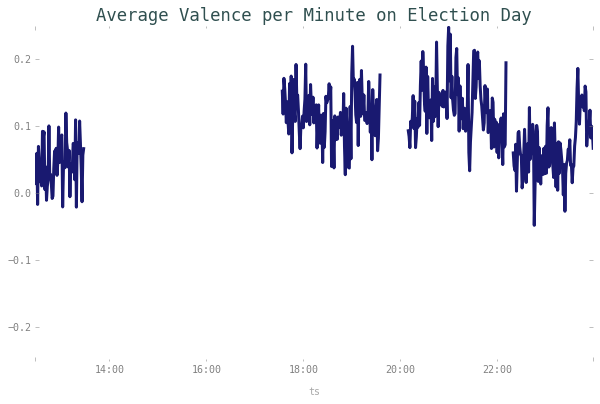

In [8]:
d = "2016-11-08"
T['comp'][d].resample("1Min").mean().plot(kind='line')
plt.title("Average Valence per Minute on Election Day")
plt.ylim(-.25,.25)
plt.show()

The gaps occur because the data were not collected continuously. Despite the noise, notice how the emotion trends up and down over the course of the day. Take a look at the trends for each of the 12 data collection days.

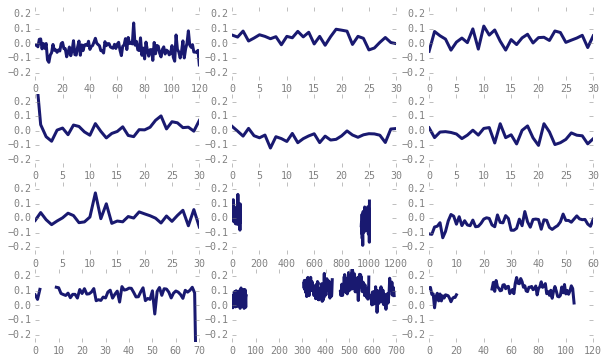

In [9]:
dates = ["10-19","10-20","10-24","10-26","11-01","11-02","11-03","11-05","11-06","11-07","11-08","11-09"]
fig = plt.figure()
fig.title = "Monitoring Twitter Sentiment over 12 days"
for i,d in enumerate(dates):
    d_ = "2016-" + d
    plt.subplot(4,3,i+1)
    plt.plot(T['comp'][d_].resample("1Min").mean().as_matrix())
    #plt.title("Average Valence per Minute on "+d)
    plt.ylim(-.25,.25)
plt.show()

This information becomes more interesting when the days are compared to each others. The plot below shows the average emotion over time of the entire data set. Notice the pronounced, positive spike on election day.

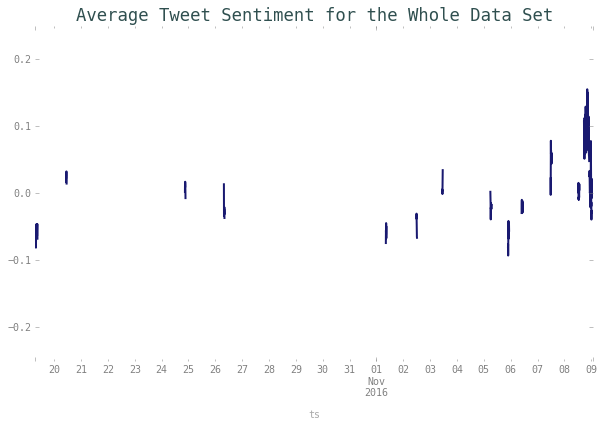

In [10]:
df['outcome'] = np.around(df['comp'].as_matrix())
df['outcome'].resample("5Min").mean().plot(kind='line',linewidth=2,figsize=(10,6))
plt.ylim(-.25,.25)
plt.title("Average Tweet Sentiment for the Whole Data Set")
plt.show()

Averages moved dramatically on Election Day. Tweets containing weblinks and user mentions fell by 75% starting on November 5. Since the average number of retweets remained stable, could this mean that more people were less conversant or less willing to share information? We don't have a suitable explanation for this anomaly, but still feel it is relevant to the analysis at hand.

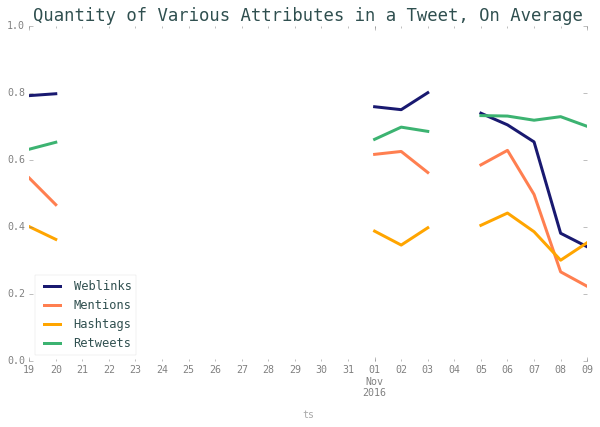

In [11]:
ax = T['n_weblinks'].resample("D").mean().plot(kind='line',label="Weblinks")
T['n_mentions'].resample("D").mean().plot(kind='line',label="Mentions",ax=ax)
T['n_hashtags'].resample("D").mean().plot(kind='line',ax=ax,label="Hashtags")
df['RT'].resample("D").mean().plot(kind='line',ax=ax,label="Retweets")
plt.ylim(0,1)
plt.legend(loc='lower left')
plt.title("Quantity of Various Attributes in a Tweet, On Average")
plt.show()

Visualizing text is a challenge. Fortunately, the analysis is not limited to the content of the tweet. The connections between Twitter users form a network. On 5 December 2016, tweets containing the keywords *Trump* and *#MAGA* were collected for post-election analysis. The hashtag is an acronym for Trump’s slogan “Make America Great Again”. An interactive version of this visualization is online at [www.derekmiller.info](http://www.derekmiller.info). The visualization represents the strength of the connection between two Twitter users. In this case, each node represents a Twitter user such as @realDonaldTrump. If @realDonaldTrump mentioned @dgmllr in a tweet, then they would share a connection represented by a grey line connecting the nodes. The graph uses an algorithm to place similar nodes near each other and unrelated nodes farther apart.

![jpg](trumpmaga.jpg)

The network for the *Trump* visualization is hardly connected. Clusters are small and spread out. On the other hand, the *#MAGA* network reveals tight, dense clusters. This may show how the keyword #MAGA is much less likely to be as neutral on average as the Trump keyword. A Trump opponent is unlikely to use a hashtag associated with support for the Trump campaign. Insights such as this reveal attributes in the data that are useful for making successful predictions.

## Machine Learning Models
![png](T2smart.png)

Many algorithms were either not well-suited for our problem or were more complicated to implement and not worth implementing initially. These include:

+ Nearest Neighbors
+ Linear and Ridge Regression
+ Mixture Models with Latent Variables
+ Kalman Filter
+ Neural Networks

Reasons for not starting with these algorithms includes no good notion of distance between tweets, a preference for classification rather than regression, no state-space model, and costly implementation. We started with simple models and ran each algorithm without tuning the model parameters to see which ones might be best suited to our problem. The following list ranks each algorithm by its accuracy:

+ Gradient Boosting, 61.83%
+ Polynomial SVM, 61.70%
+ XGBoost, 61.57%
+ Naive Bayes, 61.18%
+ Quad Discriminant Analysis, 58.28%
+ Linear Discriminant Analysis, 55.77%
+ Logistic Regression, 38.30%
+ Linear SVM, 38.30%

Of course, these scores don't tell us whether or not we have a good model. It remains to be seen how the models interpret new tweets and to see if those tweets are truly positive or negative toward Trump. Polynomial SVM and Quad Discriminant Analysis also warrant more investigation and experimentation. Since Linear SVM and Logistic Regression were such poor performers, they are likely not the best algorithms to use.

## Results

![png](T2tiny.png)

Sadly, our algorithms hardly improved with parameter tuning. Linear SVM and Logistic Regression did not improve at all. Interestingly, Quad Discriminant Analysis got the same low score as Logistic Regression and Linear SVM when the regularization parameter was greater than one. Most of the other algorithms improved when parameters were changed or tweaked. After some experimentation, the following algorithms performed best (based on the highest score achieved).

+ XGBoost (.6186)
+ Gradient Boosting (.6183)
+ Polynomial SVM (.6170)
+ Quad Discriminant Analysis (.6170)
+ Naive Bayes (.6118)
+ Linear Discriminant Analysis (.5879)
+ Logistic Regression (.3830)
+ Linear SVM (.3830)

The XGBoost algorithm improved a tiny bit tuned regularization. The largest gain in improvement came from the SVM family, where polynomial SVM was much better than Linear SVM. Quad Discriminant Analysis also gained quite a bit---from .5828 to .6170 making it go from 5th tied with Polynomial SVM for 3rd best. Tree-based models had the best performance. If we could extract other features from the text data, other models might outperform the trees. Since Linear SVM and Logistic Regression were such poor performers, we suspected that they are ill-suited to our problem. 

This could be misleading. We took the best performing algorithms and tried classifying tweets based on each algorithm's prediction. If most algorithms thought a tweet was positive, then the voting algorithm would predict that the tweet was positive. The score for this algorithm, independent of parameter tuning, was .6170. This is the same number as nearly all the naive implementations of each algorithm individually. In addition, we ran the algorithms using only two variables, the timestamp for the independent (X) variable and the sentiment for the dependent (Y) variable. Most algorithms didn't budge and some, like Naive Bayes, only budged a little. Again, .6170 was the most common score.


## Conclusion

![png](T2thumbsup.png)

Automating tweet classification based on its sentiment is a difficult problem. The similar scores and poor performance is suspicious. Even after carefully studying the data, we still don't know why this happens. We believe that there are either flaws in the data or in the problem at hand. Clearly the models are not capturing different features of the data set. One possible explanation is that election day contains tweets too far outside the norm to be considered predictable using the simple methods employed above. People were very surprised on election day and so the data may be fundamentally different and only able to predict so much. In this case, more ingenuity is needed to produce accurate predictions. For example, we could model textual data using a more sophisticated algorithm, like a Neural Network. Alternatively, we could try improving the results of the NLTK library since our current success depends heavily on its ability to successfully label the text data for classification. However, if improvements in model and feature selection fail to improve performance, then we may not have the right data.

In [12]:
T['outcome'] = np.around(T['comp'].as_matrix())
moder = sm.tsa.ARMA(T['outcome'],order=(1,1)).fit()

/usr/local/anaconda2/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


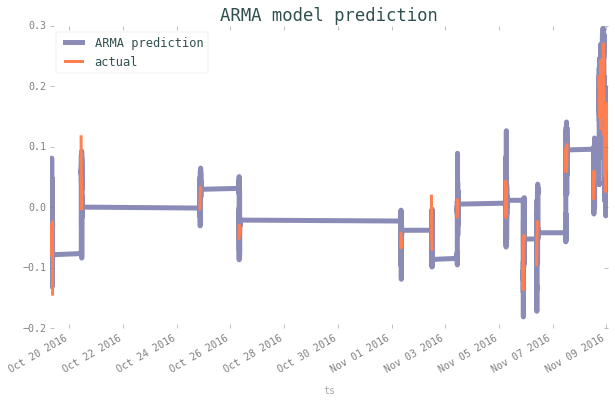

In [13]:
ax = moder.predict().plot(alpha=.5,lw=5,label="ARMA prediction")
T['outcome'].resample("10Min").mean().plot(label="actual",ax=ax)
plt.title("ARMA model prediction")
plt.legend(loc=2)
plt.show()

Individual predictions for each tweet proved to be very difficult. It was nearly impossible to get above 61% accuracy. Despite these setbacks, we are still exploring alternative classification methods. We built an ARMA model that predicts the movement of tweet sentiment over time. We might be able to combine this information with other models to improve classification accuracy. For example, our original algorithm wrongly classified some tweets as being negative. However, had they known that there were more positive tweets coming in and that more positive tweets were predicted to come in the near future, the original algorithm may have been able to change its original negative classification to a positive one. Without the prediction information, it could not have made an accurate prediction. We don't have a complete implementation of this enhanced classification strategy yet. However, our initial results with the ARMA model look promising. The plot above compares predicted average sentiment using an ARMA model vs the actual values observed. More data was collected on Inauguration day containing more features and more variables. Using new features and more advanced methods, we plan to complete this project with a more complete data set. We believe we will find more success with a more complete data set. Above all, we have learned that for machine learning, the data come first.

![png](T2salute.png)